### Debug environment for the MARL process by starting from simpler tasks

In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *
from utils.params import *
from utils.retrieve_sim import *

from importlib import reload
import utils

input_type = U_VELOCITY
observe_type = O_VELOCITY
observe_action = O_ACTION
reward_mode=ALL_REWARD

import os
try:
    os.mkdir('screencaps')
except:
    pass


In [7]:
# Test out centralized environment
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=2#00#250#500
test_interval=1#0#0
num_test=1#0#50
num_iteration=20#0
BATCH_SIZE=4#8#64#128
save_sim_intv=50
debug=False
num_sample=50
seed=22222
hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND

N_list = [3]
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:CentralizedConvergeContEnv-v0', N=N_, dt=0.1, Delta=0.05, #o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, 
                 reward_mode=DIST_REWARD,#|ACT_REWARD,
                 uses_boundary=True,
#                  uses_boundary=False,
                 dist_reward_func=lambda x : (np.abs(x) + 2) * (np.abs(x) + 2),
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
#     env_list[-1].mov_w = 100

AC2_list = []
for i,N_ in enumerate(N_list):
    AC2_list.append(
        AC2Agent(device, N_, env_list[i].ns, # IMPORTANT!!! use .ns for centralized, and .nf for decentralized
                 env_list[i].na, hidden, rand_modeA=rand_mode, centralized=True,
                 learning_rateA=0.01, learning_rateC=0.02, mode=1208)
    )

sim_fnames = ['AC2_centralizedTest_m1208_N{0}'.format(N_) for N_ in N_list]
memory_backup = []
AC2_hist = []
AC2_loss = []
for i,N_ in enumerate(N_list):
    AC2_loss.append([])
    memory_backup.append( ReplayMemory(1000 * env_list[i].N) )
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, memory=memory_backup[-1],
#               update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, 
              update_mode=UPDATE_PER_EPISODE, 
              reward_mode=FUTURE_REWARD_NORMALIZE|FUTURE_REWARD_YES,
              loss_history=AC2_loss[i],
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              imdir='screencaps/', useVid=False)
    )
    print("Finished training env with {0} agents for AC".format(N_))


Updated mean and stdev: -201314.69487057897 and 101270.41101979696
tensor([[[-0.9839, -0.5815],
         [-1.0983, -1.2801],
         [-0.8955, -0.7721]],

        [[-1.9003, -0.8268],
         [-0.6016, -0.4841],
         [-0.6583, -0.8418]],

        [[-0.6051, -1.0662],
         [-1.4899, -1.5666],
         [-0.5795, -1.1154]],

        [[-1.7292, -1.1572],
         [-0.8376, -0.9566],
         [-1.6180, -0.9868]]], grad_fn=<SubBackward0>) tensor([[[-2.9931]],

        [[-1.7490]],

        [[ 0.6251]],

        [[ 1.0827]]]) torch.Size([4, 3, 2]) torch.Size([4, 3, 2]) torch.Size([4, 1, 1]) Normal(loc: torch.Size([4, 3, 2]), scale: torch.Size([4, 3, 2]))
Test result at episode  0 : 
tensor([[[-0.9842, -0.8554],
         [-0.2039, -1.1880],
         [-0.0036, -0.4913]],

        [[-2.0922, -0.6396],
         [-0.2354, -0.0728],
         [ 0.1715, -0.9509]],

        [[-1.7388, -1.1147],
         [-0.3501, -0.3602],
         [-0.0298, -0.4883]],

        [[-1.2536, -0.1472],
         

In [9]:
testtt = torch.ones(4,5,6)

In [17]:
# Actual training for AC2
reload(utils.agents)
from utils.agents import *
num_episode=1000#250#500
test_interval=10*2#0
num_test=10#10#50
num_iteration=200
BATCH_SIZE=2*128#64#128
save_sim_intv=250
# hidden=8

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND
# hidden_list=[4,8,16,32]
hidden_list=[32]
N_list = [1]*len(hidden_list)
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:CentralizedConvergeContEnv-v0', N=N_, dt=0.1, Delta=0.05, #o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, 
                 reward_mode=DIST_REWARD,#|ACT_REWARD,
                 uses_boundary=True,
#                  uses_boundary=False,
                 dist_reward_func=lambda x : (np.log(np.abs(x)+1)),
#                  dist_reward_func=lambda x : np.sqrt(np.abs(x)),
#                  dist_reward_func=lambda x : (np.abs(x) + 2) * (np.abs(x) + 2), # * (np.abs(x) + 2) * (np.abs(x) + 2),
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
    env_list[-1].mov_w = 100
    env_list[-1].oob_reward = 400

AC2_list = []
for i,N_ in enumerate(N_list):
    AC2_list.append(
        AC2Agent(device, N_, env_list[i].ns, # IMPORTANT!!! use .ns for centralized, and .nf for decentralized
                 env_list[i].na, hidden_list[i], rand_modeA=rand_mode, centralized=True,
                 neg_loss_sign=False,
                 learning_rateA=0.01, learning_rateC=0.02, mode=12088, 
                 use_Closs_thres=True, Closs_threshold=0.01)
    )
mode_list=[0]

sim_fnames = ['AC2_conv_logreward_m0_N{0}'.format(N_,hidden_list[i]) for i,N_ in enumerate(N_list)]
memory_backup = []
AC2_hist = []
AC2_loss = []
for i,N_ in enumerate(N_list):
    AC2_loss.append([])
    memory_backup.append( ReplayMemory(1000 * env_list[i].N) )
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, memory=memory_backup[-1],
              update_mode=UPDATE_PER_EPISODE, #UPDATE_PER_ITERATION,
#               reward_mode=FUTURE_REWARD_NORMALIZE,
#               reward_mode=FUTURE_REWARD_YES,#|FUTURE_REWARD_NORMALIZE, #FUTURE_REWARD_YES_NORMALIZE, 
              loss_history=AC2_loss[i], #reward_mean_var=(torch.Tensor([-69600]), torch.Tensor([46290])),
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              not_use_rand_in_action=False, not_use_rand_in_test=True,
              imdir='screencaps/', useVid=False)
    )
    print("Finished training env with {0} agents for AC".format(N_))


Test result at episode  0 : 
Test result at episode  20 : 
Test result at episode  40 : 
Test result at episode  60 : 
Test result at episode  80 : 
Test result at episode  100 : 
Test result at episode  120 : 
Test result at episode  140 : 
Test result at episode  160 : 
Test result at episode  180 : 
Test result at episode  200 : 
Test result at episode  220 : 
Test result at episode  240 : 
Finished episode  0  with  199 ;
cumulative reward =  -53814.787918284994
Test result at episode  260 : 
Test result at episode  280 : 
Test result at episode  300 : 
Test result at episode  320 : 
Test result at episode  340 : 
Test result at episode  360 : 
Test result at episode  380 : 
Test result at episode  400 : 
Test result at episode  420 : 
Test result at episode  440 : 
Test result at episode  460 : 
Test result at episode  480 : 
Finished episode  0  with  199 ;
cumulative reward =  -81540.41604640352
Test result at episode  500 : 
Test result at episode  520 : 
Test result at episode

<Figure size 432x288 with 0 Axes>

In [13]:
# Code specifically for AC3
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=1000#250#500
test_interval=10*2#0
num_test=10#10#50
num_iteration=200
BATCH_SIZE=2*128#64#128
save_sim_intv=100#250
debug=False
num_sample=50
seed=22222
hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND

# mode_list = [1204,1205,1208,-1204,-1205,-1208,0]
mode_list = [1204,1205,1208,0]
N_list = [3]*len(mode_list)
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:CentralizedConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05, #o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, 
                 reward_mode=DIST_REWARD,#|ACT_REWARD,
                 uses_boundary=True,
#                  uses_boundary=False,
                 dist_reward_func=lambda x : (np.log(np.abs(x)+1)),
#                  dist_reward_func=lambda x : np.sqrt(np.abs(x)),
#                  dist_reward_func=lambda x : (np.abs(x) + 2) * (np.abs(x) + 2), # * (np.abs(x) + 2) * (np.abs(x) + 2),
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
#     env_list[-1].mov_w = 100

AC2_list = []
for i,N_ in enumerate(N_list):
    AC2_list.append(
        AC3Agent(device, N_, env_list[i].ns, # IMPORTANT!!! use .ns for centralized, and .nf for decentralized
                 env_list[i].na, hidden, rand_modeA=rand_mode, centralized=True,
                 neg_loss_sign=False,#True,
                 learning_rateA=0.01, learning_rateC=0.02, mode=mode_list[i])
    )

sim_fnames = ['AC3_centralized_posGauss_logreward_difftanhC_noBatchNormC_leak03A_m{1}_N{0}'.format(
    N_list[i],mode_list[i]) for i in range(len(N_list))]
memory_backup = []
AC2_hist = []
AC2_loss = []
for i,N_ in enumerate(N_list):
    AC2_loss.append([])
    memory_backup.append( ReplayMemory(1000 * env_list[i].N) )
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, memory=memory_backup[-1],
              update_mode=UPDATE_PER_EPISODE, #UPDATE_PER_ITERATION,
              reward_mode=FUTURE_REWARD_NORMALIZE|FUTURE_REWARD_YES,
#               reward_mode=FUTURE_REWARD_YES,#|FUTURE_REWARD_NORMALIZE, #FUTURE_REWARD_YES_NORMALIZE, 
              loss_history=AC2_loss[i], #reward_mean_var=(torch.Tensor([-69600]), torch.Tensor([46290])),
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              imdir='screencaps/', useVid=False)
    )
    print("Finished training env with {0} agents for AC".format(N_))


Updated mean and stdev: -137407.17062223068 and 52668.32849293526
Test result at episode  0 : 
Test result at episode  20 : 
Test result at episode  40 : 
Test result at episode  60 : 
Test result at episode  80 : 
Took  47  steps to converge
Finished episode  0  with  47 ;
cumulative reward =  -127132.12267942539
Test result at episode  100 : 
Test result at episode  120 : 
Test result at episode  140 : 
Test result at episode  160 : 
Test result at episode  180 : 
Took  55  steps to converge
Finished episode  0  with  55 ;
cumulative reward =  -139933.129879196
Test result at episode  200 : 
Test result at episode  220 : 
Test result at episode  240 : 
Test result at episode  260 : 
Test result at episode  280 : 
Took  15  steps to converge
Finished episode  0  with  15 ;
cumulative reward =  -62057.77780509232
Test result at episode  300 : 
Test result at episode  320 : 
Test result at episode  340 : 
Test result at episode  360 : 
Test result at episode  380 : 
Took  17  steps to c

<Figure size 432x288 with 0 Axes>

In [142]:
# More training
reward_mean_var = (torch.Tensor([-77885.03781972894]), torch.Tensor([38672.516062239236]))
sim_fnames = ['AC2_centralizedTest__m0_N{0}'.format(N_) for N_ in N_list]
for i,N_ in enumerate(N_list):
    AC2_hist[i] += train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, memory=memory_backup[i],
              update_mode=UPDATE_PER_EPISODE, #UPDATE_PER_ITERATION,
              reward_mode=FUTURE_REWARD_NORMALIZE,
#               reward_mode=FUTURE_REWARD_YES,#|FUTURE_REWARD_NORMALIZE, #FUTURE_REWARD_YES_NORMALIZE, 
              loss_history=AC2_loss[i], reward_mean_var=reward_mean_var,
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              imdir='screencaps/', useVid=False)
    print("Finished training env with {0} agents for AC".format(N_))


Test result at episode  0 : 
Test result at episode  10 : 
Test result at episode  20 : 
Test result at episode  30 : 
Test result at episode  40 : 
Test result at episode  50 : 
Test result at episode  60 : 
Test result at episode  70 : 
Test result at episode  80 : 
Test result at episode  90 : 
Test result at episode  100 : 
Test result at episode  110 : 
Test result at episode  120 : 
Test result at episode  130 : 
Test result at episode  140 : 
Test result at episode  150 : 
Test result at episode  160 : 
Test result at episode  170 : 
Test result at episode  180 : 
Test result at episode  190 : 
Finished episode  0  with  199 ;
cumulative reward =  -71448492.71058755
Test result at episode  200 : 
Test result at episode  210 : 
Test result at episode  220 : 
Test result at episode  230 : 
Test result at episode  240 : 
Test result at episode  250 : 
Test result at episode  260 : 
Test result at episode  270 : 
Test result at episode  280 : 
Test result at episode  290 : 
Test res

<Figure size 432x288 with 0 Axes>

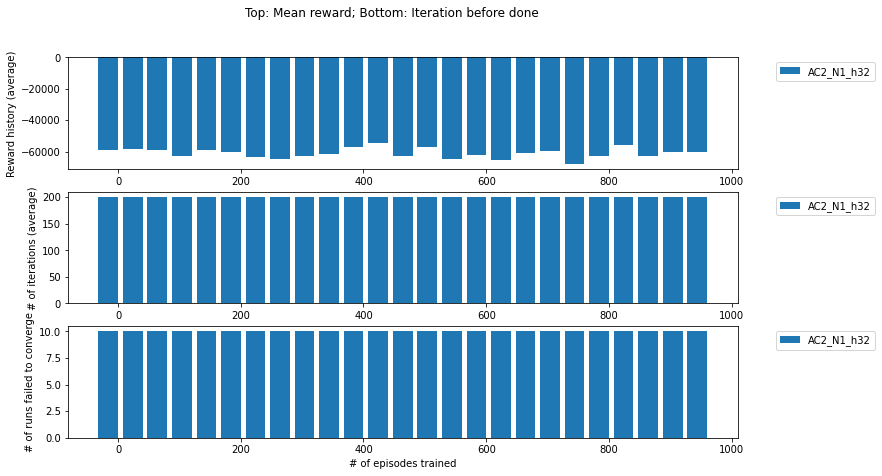

In [18]:
skip=2
plot_reward_hist([h[::skip] for h in AC2_hist], test_interval*skip, 
                 ['AC2_N{0}_h{1}'.format(N_,hidden_list[i]) for i,N_ in enumerate(N_list)], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]), bar=True)

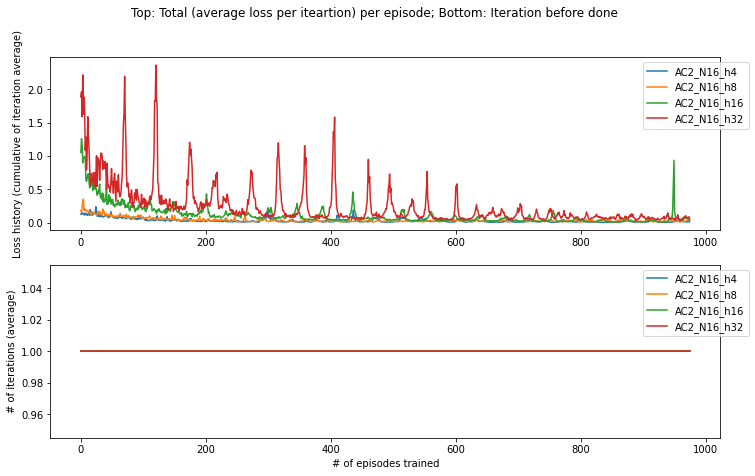

In [133]:
skip=1
plot_loss_hist(hists=[h[25::skip] for h in AC2_loss], 
               hist_names=['AC2_N{0}_h{1}'.format(N_,hidden_list[i]) for i,N_ in enumerate(N_list)], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [184]:
AC2_list[0].save_model('AC2_centralizedTest_logreward_leaky03AC_e2000_m0_rmean-1592_rstdev645_N3')

Saving model to models/AC2Agent_AC2_centralizedTest_logreward_leaky03AC_e2000_m0_rmean-1592_rstdev645_N3


In [ ]:
# reload(utils.plotting)
# from utils.plotting import *
plot_test(AC2_list[0], env_list[0], fnames=['AC2_centralizedTest_c01_N3'],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug, 
          not_use_rand=True)

In [3]:
# Code specifically for AC3
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=500#250#500
test_interval=10*2#0
num_test=10#10#50
num_iteration=200
BATCH_SIZE=64#128
save_sim_intv=100#250
debug=False
num_sample=50
seed=22222
hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND

# mode_list = [1204,1205,1208,-1204,-1205,-1208,0]
mode_list = [0]
N_list = [1]*len(mode_list)
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:CentralizedConvergeContEnv-v0', N=N_, dt=0.1, Delta=0.05, #o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, 
                 reward_mode=DIST_REWARD,#|ACT_REWARD,
                 uses_boundary=True,
#                  uses_boundary=False,
                 dist_reward_func=lambda x : (np.log(np.abs(x)+1)),
#                  dist_reward_func=lambda x : np.sqrt(np.abs(x)),
#                  dist_reward_func=lambda x : (np.abs(x) + 2) * (np.abs(x) + 2), # * (np.abs(x) + 2) * (np.abs(x) + 2),
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
#     env_list[-1].mov_w = 100

AC2_list = []
for i,N_ in enumerate(N_list):
    AC2_list.append(
        AC3Agent(device, N_, env_list[i].ns, # IMPORTANT!!! use .ns for centralized, and .nf for decentralized
                 env_list[i].na, hidden, rand_modeA=rand_mode, centralized=True,
                 neg_loss_sign=False,#True,
                 learning_rateA=0.01, learning_rateC=0.02, mode=mode_list[i])
    )

sim_fnames = ['AC3_centralized_posGauss_logreward_difftanhC_noBatchNormC_leak03A_m{1}_N{0}'.format(
    N_list[i],mode_list[i]) for i in range(len(N_list))]
memory_backup = []
AC2_hist = []
AC2_loss = []
for i,N_ in enumerate(N_list):
    AC2_loss.append([])
    memory_backup.append( ReplayMemory(1000 * env_list[i].N) )
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              iteration_cutoff=num_iteration//2, gamma=0.97, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, memory=memory_backup[-1],
              update_mode=UPDATE_PER_EPISODE, #UPDATE_PER_ITERATION,
              reward_mode=FUTURE_REWARD_NORMALIZE|FUTURE_REWARD_YES,
#               reward_mode=FUTURE_REWARD_YES,#|FUTURE_REWARD_NORMALIZE, #FUTURE_REWARD_YES_NORMALIZE, 
              loss_history=AC2_loss[i], #reward_mean_var=(torch.Tensor([-69600]), torch.Tensor([46290])),
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              not_use_rand_in_action=False, not_use_rand_in_test=True, 
              imdir='screencaps/', useVid=False)
    )
    print("Finished training env with {0} agents for AC".format(N_))


Updated mean and stdev: -299.5789643441305 and 72.0838766845371
Test result at episode  0 : 
Test result at episode  20 : 
Test result at episode  40 : 
Test result at episode  60 : 
Test result at episode  80 : 
Finished episode  0  with  199 ;
cumulative reward =  -87875.59952716566
Test result at episode  100 : 
Test result at episode  120 : 
Test result at episode  140 : 
Test result at episode  160 : 
Test result at episode  180 : 
Finished episode  0  with  199 ;
cumulative reward =  -86410.51700019455
Test result at episode  200 : 
Test result at episode  220 : 
Test result at episode  240 : 
Test result at episode  260 : 
Test result at episode  280 : 
Finished episode  0  with  199 ;
cumulative reward =  -86016.62804342654
Test result at episode  300 : 
Test result at episode  320 : 
Test result at episode  340 : 
Test result at episode  360 : 
Test result at episode  380 : 
Finished episode  0  with  199 ;
cumulative reward =  -88132.51466609257
Test result at episode  400 : 

<Figure size 432x288 with 0 Axes>

In [142]:
# More training
reward_mean_var = (torch.Tensor([-77885.03781972894]), torch.Tensor([38672.516062239236]))
sim_fnames = ['AC2_centralizedTest__m0_N{0}'.format(N_) for N_ in N_list]
for i,N_ in enumerate(N_list):
    AC2_hist[i] += train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, memory=memory_backup[i],
              update_mode=UPDATE_PER_EPISODE, #UPDATE_PER_ITERATION,
              reward_mode=FUTURE_REWARD_NORMALIZE,
#               reward_mode=FUTURE_REWARD_YES,#|FUTURE_REWARD_NORMALIZE, #FUTURE_REWARD_YES_NORMALIZE, 
              loss_history=AC2_loss[i], reward_mean_var=reward_mean_var,
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              imdir='screencaps/', useVid=False)
    print("Finished training env with {0} agents for AC".format(N_))


Test result at episode  0 : 
Test result at episode  10 : 
Test result at episode  20 : 
Test result at episode  30 : 
Test result at episode  40 : 
Test result at episode  50 : 
Test result at episode  60 : 
Test result at episode  70 : 
Test result at episode  80 : 
Test result at episode  90 : 
Test result at episode  100 : 
Test result at episode  110 : 
Test result at episode  120 : 
Test result at episode  130 : 
Test result at episode  140 : 
Test result at episode  150 : 
Test result at episode  160 : 
Test result at episode  170 : 
Test result at episode  180 : 
Test result at episode  190 : 
Finished episode  0  with  199 ;
cumulative reward =  -71448492.71058755
Test result at episode  200 : 
Test result at episode  210 : 
Test result at episode  220 : 
Test result at episode  230 : 
Test result at episode  240 : 
Test result at episode  250 : 
Test result at episode  260 : 
Test result at episode  270 : 
Test result at episode  280 : 
Test result at episode  290 : 
Test res

<Figure size 432x288 with 0 Axes>

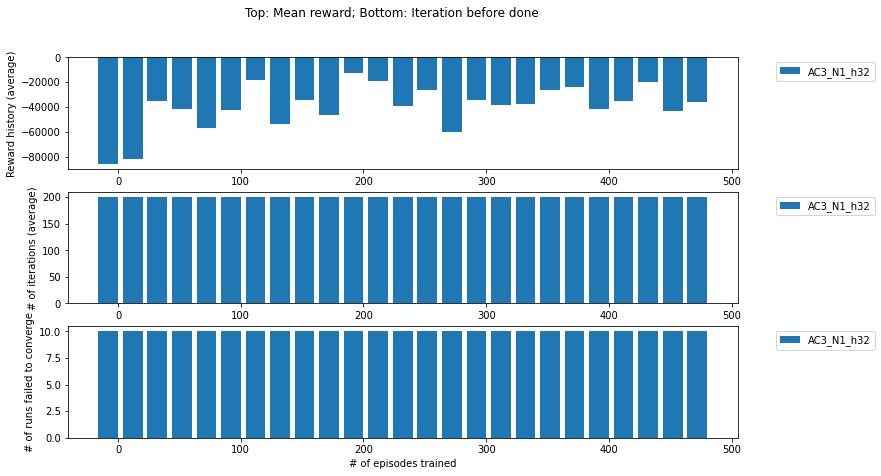

In [36]:
skip=1
plot_reward_hist([h[::skip] for h in AC2_hist], test_interval*skip, 
                 ['AC3_N{0}_h{1}'.format(N_,hidden_list[i]) for i,N_ in enumerate(N_list)], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]), bar=True)

In [24]:
len(AC2_hist)

0

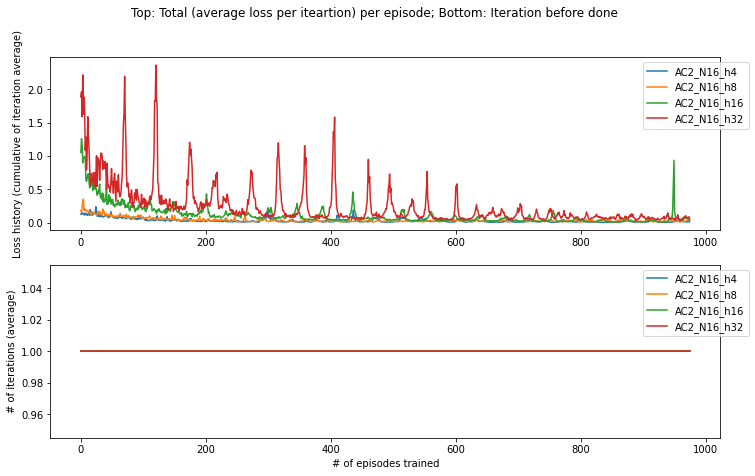

In [133]:
skip=1
plot_loss_hist(hists=[h[25::skip] for h in AC2_loss], 
               hist_names=['AC2_N{0}_h{1}'.format(N_,hidden_list[i]) for i,N_ in enumerate(N_list)], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [184]:
AC2_list[0].save_model('AC2_centralizedTest_logreward_leaky03AC_e2000_m0_rmean-1592_rstdev645_N3')

Saving model to models/AC2Agent_AC2_centralizedTest_logreward_leaky03AC_e2000_m0_rmean-1592_rstdev645_N3


In [ ]:
# reload(utils.plotting)
# from utils.plotting import *
plot_test(AC2_list[0], env_list[0], fnames=['AC2_centralizedTest_c01_N3'],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug, 
          not_use_rand=True)